<a href="https://colab.research.google.com/github/tricycle88/Sentiment-VADER-NLTK/blob/master/Istrazivanje_tekstualnih_podataka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tweepy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**TWITTER API**

- Twitter API je aplikacija uz pomoc koje mozemo da citamo i prikupljamo podatke sa Twittera. 
- Nakon registrovanja iste i autentifikacije uz pomoc kodova (ckey, csecret, atoken, asecret) aplikacija je spremna za prikupljanje podataka.

In [5]:
ckey = 'uX2j83l5Wn6AxZMOBGcDkyJH4'
csecret = 'Jd7U2hr84siWaIrgIR74SVCLpGb5UtQhEzInYuCQZDfjLaKJWY'
atoken = '327609255-iR8ht48bVLeSjKSIUOe7kYsIM6sxcXlK5g2hnpbG'
asecret = '37wIQRQTqk0dPfNbRpsy1ycxLaS5zhysRd3rCPZ5Fv344'

In [6]:
auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth, wait_on_rate_limit=True)

**PREPROCESSING**

- Ucitavanje skupa podataka i smestanje u pandas data frame.

In [7]:
# Load dataset Covid19 (20 000 tvitova)
tweet_df = pd.read_csv('/content/drive/My Drive/data/coronavirus.csv')
tweet_df.head()

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,7/2/2020,Covid19,1.280000e+18,Vaxyourfam,Vaccinate Your Family,Before canceling any upcoming childhood #vacci...,0,0,0,False
1,7/2/2020,Covid19,1.280000e+18,User_Name_Null,Bernie's Breadcrumbs 🇺🇸❌,"@Marketeer2u Ah, another mislead #UsefulIdiot,...",0,0,0,False
2,7/2/2020,Covid19,1.280000e+18,pndblog,PhilanTopic,A down payment on a COVID-free future: @GatesF...,0,0,0,False
3,7/2/2020,Covid19,1.280000e+18,MallFootwear,FootwearMall,Stay connected with latest fashion\nCall/app:0...,0,0,0,False
4,7/2/2020,Covid19,1.280000e+18,VOCALNewYork,VOCAL-NY,Rollbacks to 2019 #bailreform in NYS go into e...,0,0,0,False


Izbacivanje nepotrebnih kolona

In [8]:
tweet_df.drop(columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'like_count', 'reply_count', 'retweet_count', 'retweeted'])

,tweet
0,Before canceling any upcoming childhood #vacci...
1,"@Marketeer2u Ah, another mislead #UsefulIdiot,..."
2,A down payment on a COVID-free future: @GatesF...
3,Stay connected with latest fashion\nCall/app:0...
4,Rollbacks to 2019 #bailreform in NYS go into e...
...,...
20171,Forced into Early Retirement: Older Workers En...
20172,@miyu_miyu_12345 Please help DV2020 winners to...
20173,@RP_BCM Should have posted this while #Peacefu...
20174,Incredible turnaround in just 24 hours - focus...


Ciscenje teksta podrazumeva izbacivanje delova teksta koji ne daju nikakvo znacenje ili informaciju o podacima. (Velika slova, imena korisnika, zagrade, URLs, pojedini znakovi interpunkcije...)

In [9]:
 #  Cleaning text
import re
import string

def clean_text(tweet):
    tweet = tweet.lower() # text lowercase
    tweet = re.sub('@[^\s]+', '', tweet) # remove usernames
    tweet = re.sub('\[.*?\]', '', tweet) # remove square brackets
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet) # remove URLs
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet) # remove punctuation
    tweet = re.sub('\w*\d\w*', '', tweet) 
    tweet = re.sub('[‘’“”…]', '', tweet)
    tweet = re.sub('\n', '', tweet)
    return tweet

    
tweet = lambda x: clean_text(x)

In [10]:
data_clean = pd.DataFrame(tweet_df.tweet.apply(tweet))
data_clean

,tweet
0,before canceling any upcoming childhood vaccin...
1,ah another mislead usefulidiot got it🙄😳we are...
2,a down payment on a covidfree future reflect ...
3,stay connected with latest fashion coachmokaya...
4,rollbacks to bailreform in nys go into effect...
...,...
20171,forced into early retirement older workers enc...
20172,please help winners to get their chance this...
20173,should have posted this while peacefulprotest...
20174,incredible turnaround in just hours focused ...


**STOPWORDS**

- Reci u tekstu koje nemaju povezanost, kao ni uticaj na odredjivanje sentimenata i odredjivanje atributa.
- Pored postojecih stopwords, iz teksta sam ocistio i dodatne reci kao sto su : rt, rts, retweet. 

In [11]:
# Uklanjanje stopwords sa dodatnim recima (rt, retweet)
from nltk.corpus import stopwords
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'), additional)

data_clean1 = pd.DataFrame(data_clean['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (swords)])))
data_clean1

,tweet
0,canceling upcoming childhood vaccination wellv...
1,ah another mislead usefulidiot got it🙄😳we aren...
2,payment covidfree future reflect coronavirus r...
3,stay connected latest fashion coachmokayathehe...
4,rollbacks bailreform nys go effect today roger...
...,...
20171,forced early retirement older workers encourag...
20172,please help winners get chance unfair people l...
20173,posted peacefulprotesters burning cities looti...
20174,incredible turnaround hours focused common goo...


**TOKENIZATION**

- Tokenizacija je proces razdvajanja teksta na manje delove - tokene i neophodna je radi olaksanja algoritmu za precizniju analizu.

In [12]:
tokens = pd.DataFrame(data_clean1['tweet'].apply(nltk.word_tokenize))
tokens.head()

,tweet
0,"[canceling, upcoming, childhood, vaccination, ..."
1,"[ah, another, mislead, usefulidiot, got, it🙄😳w..."
2,"[payment, covidfree, future, reflect, coronavi..."
3,"[stay, connected, latest, fashion, coachmokaya..."
4,"[rollbacks, bailreform, nys, go, effect, today..."


**LEMMATIZATION**

- Lematizacija predstavlja svodjenje reci u tekstu na koren koriscenjem recnika i morfologijskom analizom reci.

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
def lemmatize(s):
  s = [wnl.lemmatize(word) for word in s]
  return s
tokens= tokens.assign(lemmatize = tokens.tweet.apply(lambda x: lemmatize(x)))

tokens.head()

,tweet,lemmatize
0,"[canceling, upcoming, childhood, vaccination, ...","[canceling, upcoming, childhood, vaccination, ..."
1,"[ah, another, mislead, usefulidiot, got, it🙄😳w...","[ah, another, mislead, usefulidiot, got, it🙄😳w..."
2,"[payment, covidfree, future, reflect, coronavi...","[payment, covidfree, future, reflect, coronavi..."
3,"[stay, connected, latest, fashion, coachmokaya...","[stay, connected, latest, fashion, coachmokaya..."
4,"[rollbacks, bailreform, nys, go, effect, today...","[rollback, bailreform, ny, go, effect, today, ..."


**STEMMING**

- Stemming predstavlja proces otklanjanja krajeva reci.
- Porter stemmer je najcesce koriscena tehnika zbog svoje brzine.

In [14]:
from nltk.stem.porter import PorterStemmer 
stemmer = PorterStemmer() 
tokens['stemmer'] = tokens['lemmatize'].apply(lambda x: [stemmer.stem(i) for i in x])
tokens.head()

,tweet,lemmatize,stemmer
0,"[canceling, upcoming, childhood, vaccination, ...","[canceling, upcoming, childhood, vaccination, ...","[cancel, upcom, childhood, vaccin, wellvisit, ..."
1,"[ah, another, mislead, usefulidiot, got, it🙄😳w...","[ah, another, mislead, usefulidiot, got, it🙄😳w...","[ah, anoth, mislead, usefulidiot, got, it🙄😳w, ..."
2,"[payment, covidfree, future, reflect, coronavi...","[payment, covidfree, future, reflect, coronavi...","[payment, covidfre, futur, reflect, coronaviru..."
3,"[stay, connected, latest, fashion, coachmokaya...","[stay, connected, latest, fashion, coachmokaya...","[stay, connect, latest, fashion, coachmokayath..."
4,"[rollbacks, bailreform, nys, go, effect, today...","[rollback, bailreform, ny, go, effect, today, ...","[rollback, bailreform, ny, go, effect, today, ..."


In [15]:
# Spajanje tokena nazad
tokens['stemmer'] = tokens['stemmer'].apply(lambda x: ' '.join([w for w in x]))
tokens.head()

,tweet,lemmatize,stemmer
0,"[canceling, upcoming, childhood, vaccination, ...","[canceling, upcoming, childhood, vaccination, ...",cancel upcom childhood vaccin wellvisit appoin...
1,"[ah, another, mislead, usefulidiot, got, it🙄😳w...","[ah, another, mislead, usefulidiot, got, it🙄😳w...",ah anoth mislead usefulidiot got it🙄😳w arent o...
2,"[payment, covidfree, future, reflect, coronavi...","[payment, covidfree, future, reflect, coronavi...",payment covidfre futur reflect coronaviru resp...
3,"[stay, connected, latest, fashion, coachmokaya...","[stay, connected, latest, fashion, coachmokaya...",stay connect latest fashion coachmokayathehear...
4,"[rollbacks, bailreform, nys, go, effect, today...","[rollback, bailreform, ny, go, effect, today, ...",rollback bailreform ny go effect today roger e...


In [16]:
nltk.download('vader_lexicon')
# Analiza sentimenata NLTK 

def sentiment_analyze(stemmer):
  score = SentimentIntensityAnalyzer().polarity_scores(stemmer)
  neg = score['neg'] 
  pos = score['pos']
  neu = score['neu']

  return SentimentIntensityAnalyzer().polarity_scores(stemmer)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


**Analiza sentimenata**

In [17]:
tokens['polarity']= tokens['stemmer'].apply(sentiment_analyze)
tokens['compound'] = tokens['polarity'].apply(lambda d:d['compound'])
tokens.head()

,tweet,lemmatize,stemmer,polarity,compound
0,"[canceling, upcoming, childhood, vaccination, ...","[canceling, upcoming, childhood, vaccination, ...",cancel upcom childhood vaccin wellvisit appoin...,"{'neg': 0.182, 'neu': 0.818, 'pos': 0.0, 'comp...",-0.25
1,"[ah, another, mislead, usefulidiot, got, it🙄😳w...","[ah, another, mislead, usefulidiot, got, it🙄😳w...",ah anoth mislead usefulidiot got it🙄😳w arent o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00
2,"[payment, covidfree, future, reflect, coronavi...","[payment, covidfree, future, reflect, coronavi...",payment covidfre futur reflect coronaviru resp...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00
3,"[stay, connected, latest, fashion, coachmokaya...","[stay, connected, latest, fashion, coachmokaya...",stay connect latest fashion coachmokayathehear...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00
4,"[rollbacks, bailreform, nys, go, effect, today...","[rollback, bailreform, ny, go, effect, today, ...",rollback bailreform ny go effect today roger e...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00


In [18]:
tokens['sentiment'] = tokens['compound'].apply(lambda score: 'positive' if score>=0.05 else 'negative' if score<=-0.05 else 'neutral')
tokens.head()

,tweet,lemmatize,stemmer,polarity,compound,sentiment
0,"[canceling, upcoming, childhood, vaccination, ...","[canceling, upcoming, childhood, vaccination, ...",cancel upcom childhood vaccin wellvisit appoin...,"{'neg': 0.182, 'neu': 0.818, 'pos': 0.0, 'comp...",-0.25,negative
1,"[ah, another, mislead, usefulidiot, got, it🙄😳w...","[ah, another, mislead, usefulidiot, got, it🙄😳w...",ah anoth mislead usefulidiot got it🙄😳w arent o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,neutral
2,"[payment, covidfree, future, reflect, coronavi...","[payment, covidfree, future, reflect, coronavi...",payment covidfre futur reflect coronaviru resp...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,neutral
3,"[stay, connected, latest, fashion, coachmokaya...","[stay, connected, latest, fashion, coachmokaya...",stay connect latest fashion coachmokayathehear...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,neutral
4,"[rollbacks, bailreform, nys, go, effect, today...","[rollback, bailreform, ny, go, effect, today, ...",rollback bailreform ny go effect today roger e...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.00,neutral


**VIZUALIZACIJA**

Prikaz raspodele sentimenata nad celim datasetom.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


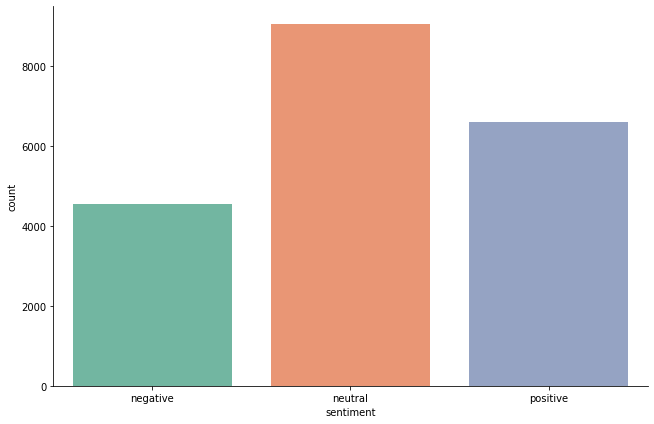

In [19]:
import seaborn as sns

sns.catplot(x='sentiment', data=tokens, kind="count", height=6, aspect=1.5, palette="Set2")
plt.show()

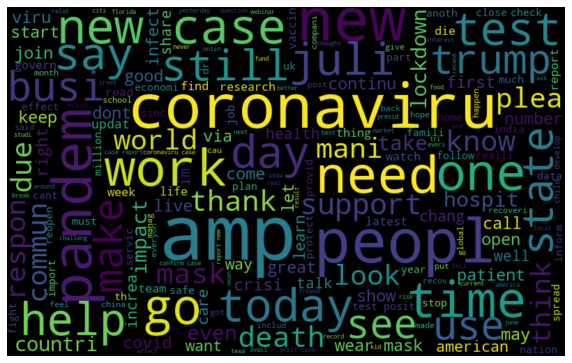

In [20]:
# Word cloud za ceo dataset
all_words = ' '.join([text for text in tokens['stemmer']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [26]:
# Reci u tvitovima koji potencijalno negiraju koronu.

negate_words = ['deep state', 'scam', '5g', 'fake virus', 'lobby']
negiranje_covid19 = tokens[tokens.stemmer.str.contains('|'.join(negate_words))]
negiranje_covid19

,tweet,lemmatize,stemmer,polarity,compound,sentiment
239,"[ive, read, thread, people, totally, convinced...","[ive, read, thread, people, totally, convinced...",ive read thread peopl total convinc scam none ...,"{'neg': 0.291, 'neu': 0.709, 'pos': 0.0, 'comp...",-0.5719,negative
255,"[yer, bio, says, scam, kind, scam, doesnt, exi...","[yer, bio, say, scam, kind, scam, doesnt, exis...",yer bio say scam kind scam doesnt exist bad ma...,"{'neg': 0.358, 'neu': 0.339, 'pos': 0.303, 'co...",-0.2846,negative
361,"[shocking, scam, bigger, commonwealth, alleged...","[shocking, scam, bigger, commonwealth, alleged...",shock scam bigger commonwealth allegedli emerg...,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'comp...",-0.7430,negative
579,"[shocking, scam, bigger, commonwealth, alleged...","[shocking, scam, bigger, commonwealth, alleged...",shock scam bigger commonwealth allegedli emerg...,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'comp...",-0.7430,negative
1045,"[covidsuffolk, alert, unemployment, scams, rel...","[covidsuffolk, alert, unemployment, scam, rela...",covidsuffolk alert unemploy scam relat report ...,"{'neg': 0.266, 'neu': 0.576, 'pos': 0.158, 'co...",-0.3612,negative
1946,"[get, go, warning, something, rotten, behind, ...","[get, go, warning, something, rotten, behind, ...",get go warn someth rotten behind plandem scamd...,"{'neg': 0.402, 'neu': 0.598, 'pos': 0.0, 'comp...",-0.5719,negative
3275,"[scamalert, watch, fake, nationalinsurance, re...","[scamalert, watch, fake, nationalinsurance, re...",scamalert watch fake nationalinsur refund scam...,"{'neg': 0.383, 'neu': 0.617, 'pos': 0.0, 'comp...",-0.4767,negative
3595,"[never, really, virus, instead, election, last...","[never, really, virus, instead, election, last...",never realli viru instead elect last gasp deep...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3747,"[ondo, state, people, still, scam]","[ondo, state, people, still, scam]",ondo state peopl still scam,"{'neg': 0.481, 'neu': 0.519, 'pos': 0.0, 'comp...",-0.5719,negative
4938,"[scammers, pretending, contact, tracers, profi...","[scammer, pretending, contact, tracer, profit,...",scammer pretend contact tracer profit current ...,"{'neg': 0.151, 'neu': 0.538, 'pos': 0.312, 'co...",0.3612,positive


Vidimo da se uglavnom tvitovi koji negiraju virus Korona nalaze medju tvitovima sa negativnim sentimentom.

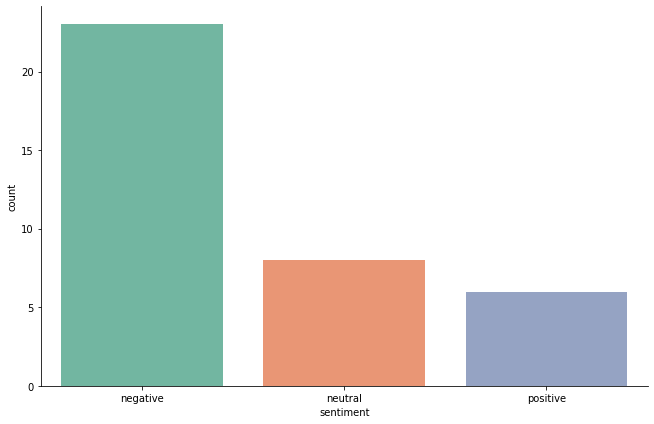

In [28]:
# Raspodela tvitova koji potencijalno negiraju Covid19
sns.catplot(x='sentiment', data=negiranje_covid19, kind="count", height=6, aspect=1.5, palette="Set2")
plt.show()

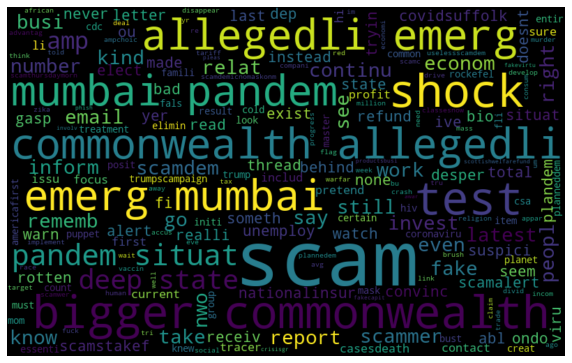

In [29]:
# Word cloud za tvitove koje potencijalno negiraju Covid19
all_words = ' '.join([text for text in negiranje_covid19['stemmer']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(max_features=15)
X = vec.fit_transform(negiranje_covid19['stemmer'])
pd.DataFrame(X.toarray(), columns = vec.get_feature_names())

,allegedli,amp,bigger,busi,commonwealth,deep,emerg,mumbai,pandem,scam,scammer,shock,situat,state,test
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.352603,0.000000,0.352603,0.000000,0.352603,0.000000,0.352603,0.352603,0.331373,0.185499,0.000000,0.352603,0.331373,0.000000,0.000000
3,0.352603,0.000000,0.352603,0.000000,0.352603,0.000000,0.352603,0.352603,0.331373,0.185499,0.000000,0.352603,0.331373,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.728704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.684829,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.488463,0.000000,0.000000,0.000000,0.872584,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.779293,0.000000,0.626660,0.000000,0.000000
